# Visualizing CNN layers with PyTorch and FashionMNIST dataset

Simple example that starts with a trained CNN (from PyTorch_Classifier_FashionMNIST.ipynb) and implements some visualizations of Feature Maps

## Load the test dataset

In [4]:
# Import PyTorch
import torch
import torchvision

# Import FashionMNIST dataset and tools
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Transformation from PIL to Tensors
xformr2Tensor = transforms.ToTensor()

testing_data = FashionMNIST(root='./data', train=False, download=True, transform=xformr2Tensor)

# Verify we got some data
print("Testing Data: ", len(testing_data), " images");

# Setup DataLoaders
batch_size = 20
testing_data_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

# FashionMNIST data labels for 10 classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Testing Data:  10000  images


## Sanity check visualizing a few images¶
Pick up a few random images and take a peek to make sure we have proper 28x28 pixel grayscale images, as expected

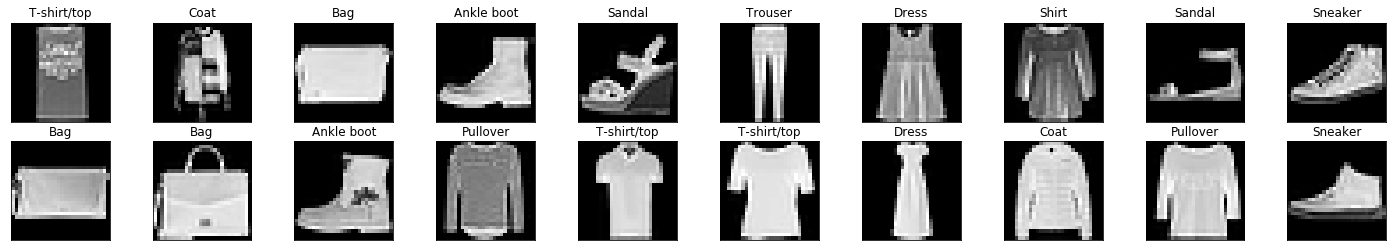

In [5]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Get one batch of images from the training set
image_iter = iter(testing_data_loader)
images, labels = image_iter.next()
images = images.numpy()

# Display images and their labels
fig = plt.figure(figsize=(25,4))
for i in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(classes[labels[i]])

## Define the Convolutional Neural Network (CNN)

Use the same simple CNN (from PyTorch_CNN_Visualization_FashionMNIST.ipynb) with the followng layers:
1. Convolutional layer
2. Maxpooling layer
3. Convolutional layer
4. Maxpooling layer
5. Fully connected layer
6. Dropout layer
7. Fully connected layer


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
    
        # Define network building blocks
    
        # First Convolutional Layer
        # 1 input, 10 outputs, 3x3 filter kernel
        # Input image size: 28x28
        # Output Width = (Width - Filter_Width + 2*Padding)/Stride + 1
        # Output Width = (28 - 3 + 2*0)/1 + 1 = 26
        # Output image size: 26x26
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # Maxpool layer, size 2, stride 2
        # Output Image size: 13x13
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second Convolutional Layer:
        # 10 inputs, 20 outputs, 3x3 filter kernel
        # Input image size: 13x13
        # Output Width = (Width - Filter_Width + 2*Padding)/Stride + 1
        # Output Width = (13 - 3 + 2*0)/1 + 1 = 11
        # Output image size: 11x11
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # After second max pool, image size will be 5 x 5 (5.5 rounded down to 5)
        
        # Fully Connected (Linear) Layer
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # Dropdown to prevent over-fitting
        self.drop = nn.Dropout(p=0.4)
        
        # Final layer with 10 outputs
        self.final = nn.Linear(50,10)
        
    #define the feedforward structure
    def forward(self, x):
        
        # First 2 convolution + ReLU + Max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Prepare for Linear layer
        x = x.view(x.size(0), -1)
        
        # Linear -> Dropout -> Liner
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.final(x)
        
        return x
    
# Instantiate 
net = Net()

# Print out for sanity check
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (final): Linear(in_features=50, out_features=10, bias=True)
)


## Load in pre-trained net
Load in the previously saved net trained with PyTorch_Classifier_FashionMNIST.ipynb

In [7]:
model_dir = "saved_models/"
model_name = "FashionMNIST_classifier.pt"

# Load
net.load_state_dict(torch.load(model_dir+model_name))

print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (final): Linear(in_features=50, out_features=10, bias=True)
)


## Feature Visualization

First convolutional layer


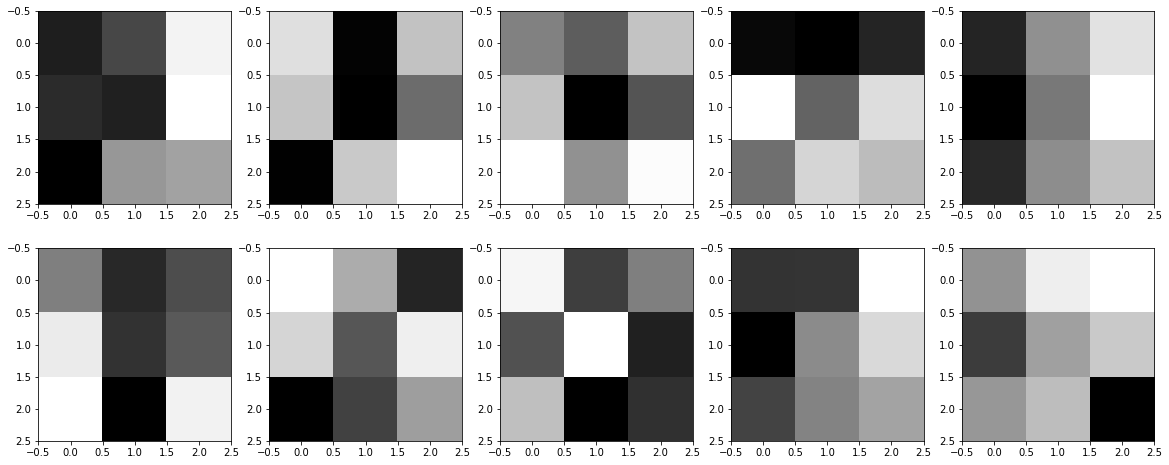

In [9]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

# plot 10 weights for layer 1
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()


Second Convolutional layer:


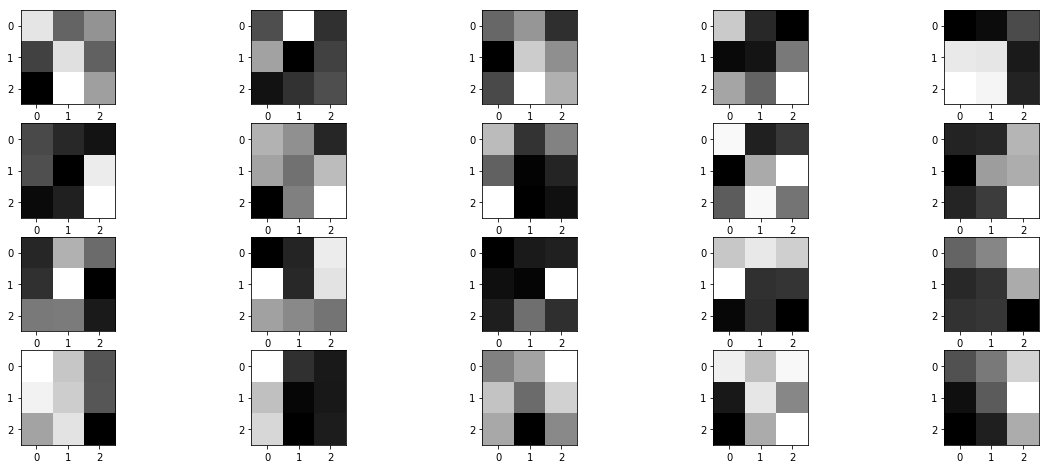

In [15]:
# Weigths of the second convolutional layer
weights = net.conv2.weight.data
weights_arr = weights.numpy()

# plot 20 weights for layer 2
fig=plt.figure(figsize=(20, 8))
rows = 4
cols = 5
for i in range(0, rows*cols):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(weights_arr[i][0], cmap='gray')
    
print('Second Convolutional layer:')
plt.show()


## Activation maps by applying CNN filters to image
### First Convolutional Layer

Activation Maps for First Convolutional Layer:


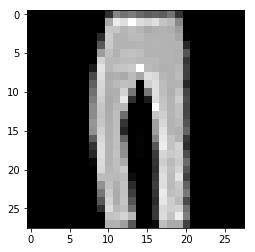

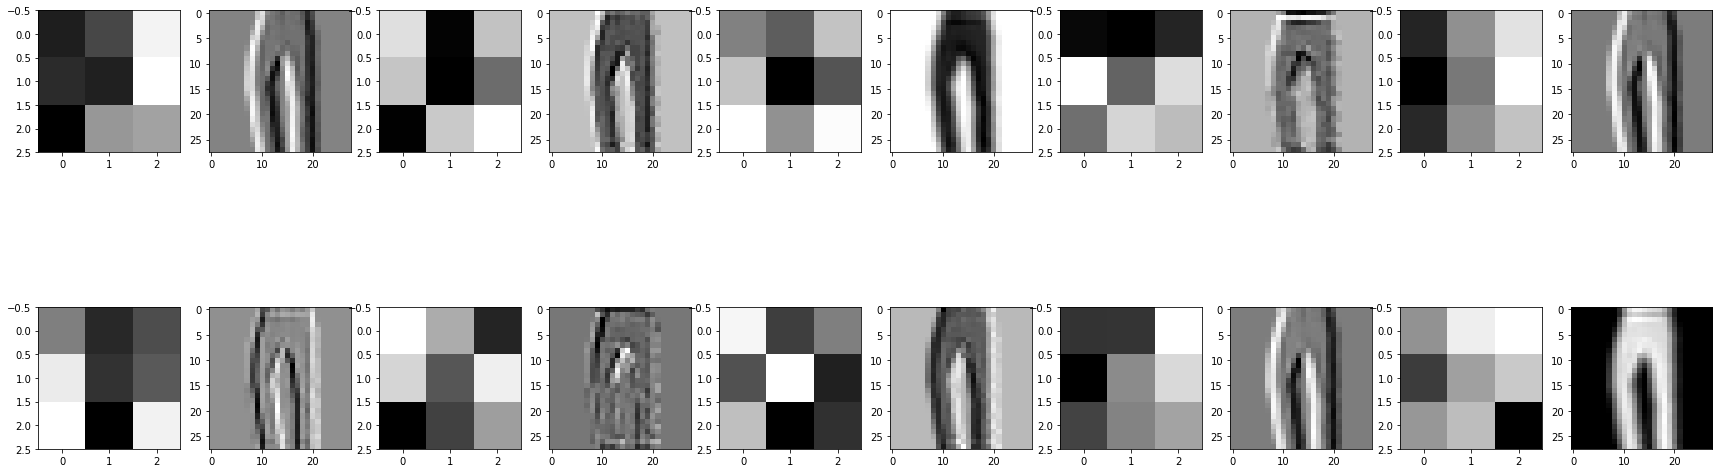

In [13]:
import cv2
import random

# Get one batch of images from the test set
image_iter = iter(testing_data_loader)
images, labels = image_iter.next()
images = images.numpy()

# Pick a random image
img = np.squeeze(images[random.randint(0, 19)])

plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
weights_arr = weights.numpy()

fig=plt.figure(figsize=(30, 10))
rows = 2
cols = 5*2
for i in range(0, rows*cols):
    fig.add_subplot(rows, cols, i+1)
    if ((i%2)==0):
        plt.imshow(weights_arr[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, weights_arr[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')


print("Activation Maps for first Convolutional Layer:")
plt.show()

### Second Convolutional Layer

Activation Maps for Second Convolutional Layer:


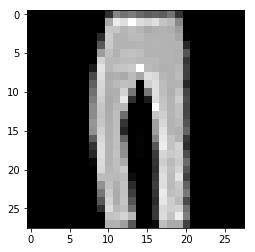

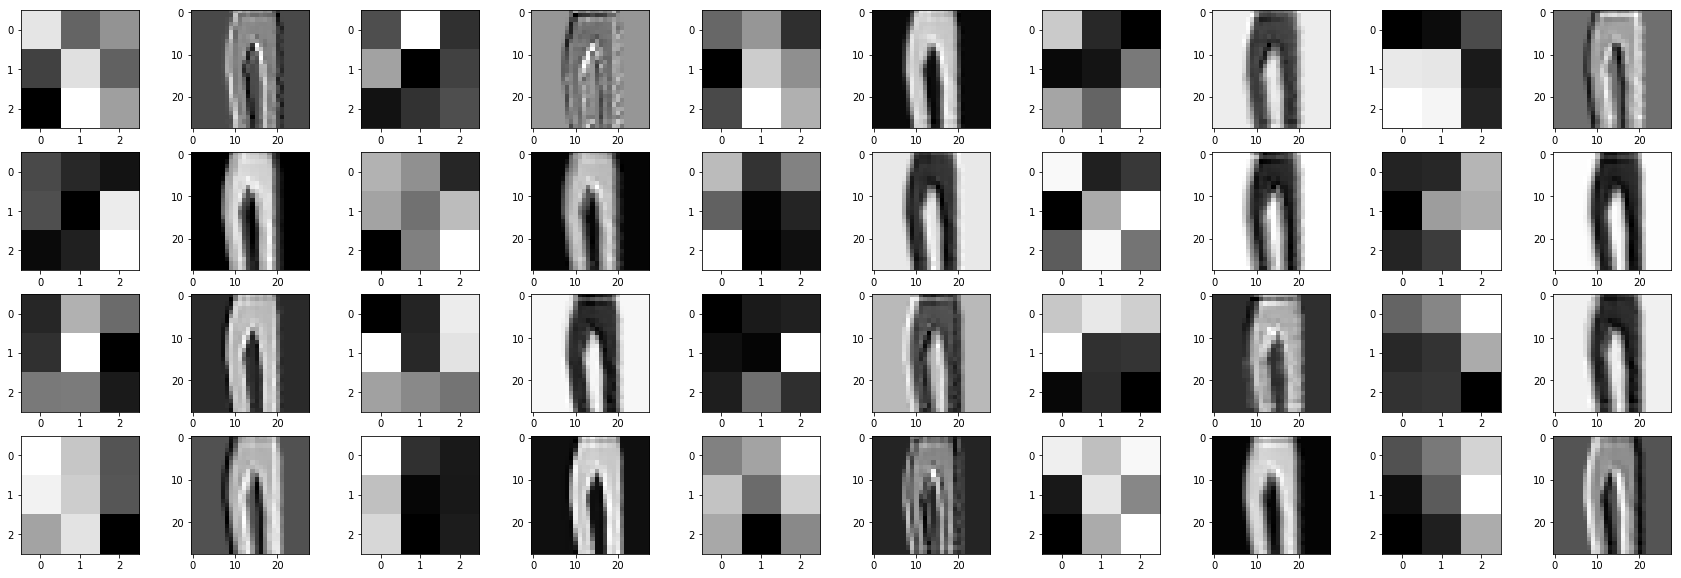

In [14]:
plt.imshow(img, cmap='gray')

# Get weights for the second Convolutional layer
weights = net.conv2.weight.data
weights_arr = weights.numpy()

fig=plt.figure(figsize=(30, 10))
rows = 4
cols = 5*2
for i in range(0, rows*cols):
    fig.add_subplot(rows, cols, i+1)
    if ((i%2)==0):
        plt.imshow(weights_arr[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, weights_arr[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')


print("Activation Maps for Second Convolutional Layer:")
plt.show()